In [1]:
!pip install pytorch-ignite torchsummary

In [2]:
import torch
import torchvision
import ignite

print(*map(lambda m: ": ".join((m.__name__, m.__version__)), (torch, torchvision, ignite)), sep="\n")

torch: 1.10.0+cu113
torchvision: 0.11.1+cu113
ignite: 0.4.8


## Import Libraries

Note: torchsummary is an optional dependency here.

In [3]:
import os
import logging
import matplotlib.pyplot as plt

import numpy as np

from torchsummary import summary

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision.transforms as transforms
import torchvision.utils as vutils

from ignite.engine import Engine, Events
import ignite.distributed as idist

## Reproductibility and logging details


In [4]:
ignite.utils.manual_seed(999)

In [5]:
ignite.utils.setup_logger(name="ignite.distributed.auto.auto_dataloader", level=logging.WARNING)
ignite.utils.setup_logger(name="ignite.distributed.launcher.Parallel", level=logging.WARNING)

<Logger ignite.distributed.launcher.Parallel (WARNING)>

In [6]:
import math
from torch.optim import Optimizer

class SGD(Optimizer):

    def __init__(self, params, lr=.01, momentum=0, dampening=0,
                 weight_decay=0, nesterov=False):
        defaults = dict(lr=lr, momentum=momentum, dampening=dampening,
                        weight_decay=weight_decay, nesterov=nesterov)
        super(SGD, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(SGD, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('nesterov', False)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            weight_decay = group['weight_decay']
            momentum = group['momentum']
            dampening = group['dampening']
            nesterov = group['nesterov']

            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad.data
                if weight_decay != 0:
                    d_p.add_(weight_decay, p.data)
                # Apply learning rate  
                d_p.mul_(group['lr'])
                if momentum != 0:
                    param_state = self.state[p]
                    if 'momentum_buffer' not in param_state:
                        buf = param_state['momentum_buffer'] = torch.zeros_like(p.data)
                        buf.mul_(momentum).add_(d_p)
                    else:
                        buf = param_state['momentum_buffer']
                        buf.mul_(momentum).add_(1 - dampening, d_p)
                    if nesterov:
                        d_p = d_p.add(momentum, buf)
                    else:
                        d_p = buf

                p.data.add_(-1, d_p)

        return loss

In [7]:
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor

image_size = 64
transform = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

data_transform = transforms.Compose(
    [
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

train_data = datasets.CIFAR10(root='./data', train=True, transform = data_transform, download=True)

test_data = datasets.CIFAR10(root='./data', train=False, transform = data_transform, download=True)
      
                             
print(train_data)
print(test_data)

Files already downloaded and verified
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=64, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(64, 64))
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               Resize(size=64, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(64, 64))
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )


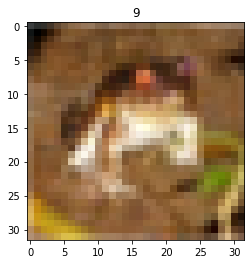

In [8]:
import matplotlib.pyplot as plt
plt.imshow(train_data.data[0])
plt.title('%i' % train_data.targets[1])
plt.show()

In [9]:
batch_size = 128

train_dataloader = idist.auto_dataloader(
    train_data, 
    batch_size=batch_size, 
    num_workers=2, 
    shuffle=True, 
    drop_last=True,
)

test_dataloader = idist.auto_dataloader(
    test_data, 
    batch_size=batch_size, 
    num_workers=2, 
    shuffle=False, 
    drop_last=True,
)

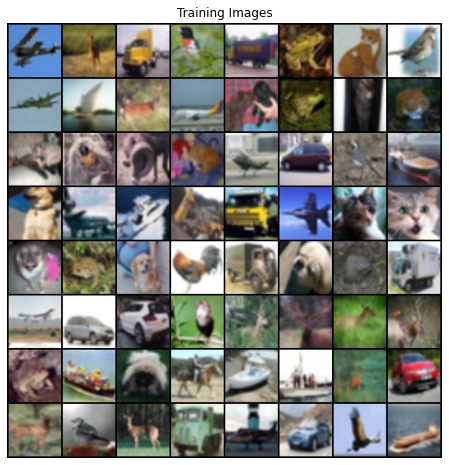

In [10]:
batch_size = 128
real_batch = next(iter(train_dataloader))

plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

## Models for GAN

### Generator

The latent space dimension of input vectors for the generator is a key parameter of GAN.

In [11]:
latent_dim = 100

In [12]:
class Generator3x64x64(nn.Module):

    def __init__(self, latent_dim):
        super(Generator3x64x64, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            # state size. 512 x 4 x 4
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # state size. 256 x 8 x 8
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # state size. 128 x 16 x 16
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # state size. 64 x 32 x 32
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
            # final state size. 3 x 64 x 64
        )

    def forward(self, x):
        x = self.model(x)
        return x

As for dataloading, distributed models requires some specifics that `idist` adresses providing the [`auto_model`](https://pytorch.org/ignite/v0.4.5/generated/ignite.distributed.auto.auto_model.html#auto-model) helper.

In [13]:
netG = idist.auto_model(Generator3x64x64(latent_dim))

Note that the model is automatically moved to the best device detected by `idist`.

In [14]:
idist.device()

device(type='cuda')

In [15]:
summary(netG, (latent_dim, 1, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]         819,200
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
              ReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-5            [-1, 256, 8, 8]             512
              ReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,288
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         131,072
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13            [-1, 3, 64, 64]           3,072
             Tanh-14            [-1, 3,

### Discriminator

In [16]:
class Discriminator3x64x64(nn.Module):
    def __init__(self):
        super(Discriminator3x64x64, self).__init__()
        self.model = nn.Sequential(
            # input is 3 x 64 x 64
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 64 x 32 x 32
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 128 x 16 x 16
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 256 x 8 x 8
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 512 x 4 x 4
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.model(x)
        return x

In [17]:
netD = idist.auto_model(Discriminator3x64x64())
summary(netD, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           3,072
         LeakyReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3          [-1, 128, 16, 16]         131,072
       BatchNorm2d-4          [-1, 128, 16, 16]             256
         LeakyReLU-5          [-1, 128, 16, 16]               0
            Conv2d-6            [-1, 256, 8, 8]         524,288
       BatchNorm2d-7            [-1, 256, 8, 8]             512
         LeakyReLU-8            [-1, 256, 8, 8]               0
            Conv2d-9            [-1, 512, 4, 4]       2,097,152
      BatchNorm2d-10            [-1, 512, 4, 4]           1,024
        LeakyReLU-11            [-1, 512, 4, 4]               0
           Conv2d-12              [-1, 1, 1, 1]           8,192
          Sigmoid-13              [-1, 1, 1, 1]               0
Total params: 2,765,568
Trainable param

In [18]:
criterion = nn.BCELoss()

A batch of `64` fixed samples will be used for generating images from throughout the training. This will allow a qualitative evaluation throughout the training progress.

In [19]:
fixed_noise = torch.randn(64, latent_dim, 1, 1, device=idist.device())

Finally, two separate optimizers are set up, one for the generator, and one for the discriminator. Yet, another helper method [`auto_optim`](https://pytorch.org/ignite/v0.4.5/generated/ignite.distributed.auto.auto_optim.html#auto-optim) provided by `idist` will help to adapt optimizer for distributed configurations. 

In [20]:
optimizerD = idist.auto_optim(
    SGD(netD.parameters(), lr=0.0002)
)

optimizerG = idist.auto_optim(
    SGD(netG.parameters(), lr=0.0002)
)

In [21]:
real_label = 1
fake_label = 0


def training_step(engine, data):
    # Set the models for training
    netG.train()
    netD.train()

    ############################
    # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
    ###########################
    ## Train with all-real batch
    netD.zero_grad()
    # Format batch
    real = data[0].to(idist.device())
    b_size = real.size(0)
    label = torch.full((b_size,), real_label, dtype=torch.float, device=idist.device())
    # Forward pass real batch through D
    output1 = netD(real).view(-1)
    # Calculate loss on all-real batch
    errD_real = criterion(output1, label)
    # Calculate gradients for D in backward pass
    errD_real.backward()

    ## Train with all-fake batch
    # Generate batch of latent vectors
    noise = torch.randn(b_size, latent_dim, 1, 1, device=idist.device())
    # Generate fake image batch with G
    fake = netG(noise)
    label.fill_(fake_label)
    # Classify all fake batch with D
    output2 = netD(fake.detach()).view(-1)
    # Calculate D's loss on the all-fake batch
    errD_fake = criterion(output2, label)
    # Calculate the gradients for this batch, accumulated (summed) with previous gradients
    errD_fake.backward()
    # Compute error of D as sum over the fake and the real batches
    errD = errD_real + errD_fake
    # Update D
    optimizerD.step()

    ############################
    # (2) Update G network: maximize log(D(G(z)))
    ###########################
    netG.zero_grad()
    label.fill_(real_label)  # fake labels are real for generator cost
    # Since we just updated D, perform another forward pass of all-fake batch through D
    output3 = netD(fake).view(-1)
    # Calculate G's loss based on this output
    errG = criterion(output3, label)
    # Calculate gradients for G
    errG.backward()
    # Update G
    optimizerG.step()

    return {
        "Loss_G" : errG.item(),
        "Loss_D" : errD.item(),
        "D_x": output1.mean().item(),
        "D_G_z1": output2.mean().item(),
        "D_G_z2": output3.mean().item(),
    }

In [22]:
trainer = Engine(training_step)

In [23]:
def initialize_fn(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [24]:
@trainer.on(Events.STARTED)
def init_weights():
    netD.apply(initialize_fn)
    netG.apply(initialize_fn)

In [25]:
G_losses = []
D_losses = []


@trainer.on(Events.ITERATION_COMPLETED)
def store_losses(engine):
    o = engine.state.output
    G_losses.append(o["Loss_G"])
    D_losses.append(o["Loss_D"])

In [26]:
img_list = []


@trainer.on(Events.ITERATION_COMPLETED(every=500))
def store_images(engine):
    with torch.no_grad():
        fake = netG(fixed_noise).cpu()
    img_list.append(fake)

In [27]:
from ignite.metrics import FID, InceptionScore

In [28]:
fid_metric = FID(device=idist.device())

In [29]:
is_metric = InceptionScore(device=idist.device(), output_transform=lambda x: x[0])

In [30]:
import PIL.Image as Image


def interpolate(batch):
    arr = []
    for img in batch:
        pil_img = transforms.ToPILImage()(img)
        resized_img = pil_img.resize((299,299), Image.BILINEAR)
        arr.append(transforms.ToTensor()(resized_img))
    return torch.stack(arr)


def evaluation_step(engine, batch):
    with torch.no_grad():
        noise = torch.randn(batch_size, latent_dim, 1, 1, device=idist.device())
        netG.eval()
        fake_batch = netG(noise)
        fake = interpolate(fake_batch)
        real = interpolate(batch[0])
        return fake, real

In [31]:
evaluator = Engine(evaluation_step)
fid_metric.attach(evaluator, "fid")
is_metric.attach(evaluator, "is")

In [32]:
fid_values = []
is_values = []


@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(engine):
    evaluator.run(test_dataloader,max_epochs=1)
    metrics = evaluator.state.metrics
    fid_score = metrics['fid']
    is_score = metrics['is']
    fid_values.append(fid_score)
    is_values.append(is_score)
    print(f"Epoch [{engine.state.epoch}/5] Metric Scores")
    print(f"*   FID : {fid_score:4f}")
    print(f"*    IS : {is_score:4f}")

In [33]:
from ignite.metrics import RunningAverage


RunningAverage(output_transform=lambda x: x["Loss_G"]).attach(trainer, 'Loss_G')
RunningAverage(output_transform=lambda x: x["Loss_D"]).attach(trainer, 'Loss_D')

In [34]:
from ignite.contrib.handlers import ProgressBar


ProgressBar().attach(trainer, metric_names=['Loss_G','Loss_D'])
ProgressBar().attach(evaluator)

In [35]:
def training(*args):
    trainer.run(train_dataloader, max_epochs=30)

In [36]:
with idist.Parallel(backend='nccl') as parallel:
    parallel.run(training)

/tmp/ipykernel_52624/781053462.py:49: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:1050.)
  p.data.add_(-1, d_p)


[1/390]   0%|           [00:00<?]

[1/78]   1%|1          [00:00<?]

Epoch [1/5] Metric Scores
*   FID : 0.154987
*    IS : 1.032594


[1/390]   0%|           [00:00<?]

[1/78]   1%|1          [00:00<?]

Epoch [2/5] Metric Scores
*   FID : 0.156317
*    IS : 1.036431


[1/390]   0%|           [00:00<?]

[1/78]   1%|1          [00:00<?]

Epoch [3/5] Metric Scores
*   FID : 0.156838
*    IS : 1.028587


[1/390]   0%|           [00:00<?]

[1/78]   1%|1          [00:00<?]

Epoch [4/5] Metric Scores
*   FID : 0.156019
*    IS : 1.027910


[1/390]   0%|           [00:00<?]

[1/78]   1%|1          [00:00<?]

Epoch [5/5] Metric Scores
*   FID : 0.155092
*    IS : 1.021003


[1/390]   0%|           [00:00<?]

[1/78]   1%|1          [00:00<?]

Epoch [6/5] Metric Scores
*   FID : 0.159749
*    IS : 1.025381


[1/390]   0%|           [00:00<?]

[1/78]   1%|1          [00:00<?]

Epoch [7/5] Metric Scores
*   FID : 0.158360
*    IS : 1.020004


[1/390]   0%|           [00:00<?]

[1/78]   1%|1          [00:00<?]

Epoch [8/5] Metric Scores
*   FID : 0.160625
*    IS : 1.023228


[1/390]   0%|           [00:00<?]

[1/78]   1%|1          [00:00<?]

Epoch [9/5] Metric Scores
*   FID : 0.153655
*    IS : 1.020544


[1/390]   0%|           [00:00<?]

[1/78]   1%|1          [00:00<?]

Epoch [10/5] Metric Scores
*   FID : 0.154783
*    IS : 1.045060


[1/390]   0%|           [00:00<?]

[1/78]   1%|1          [00:00<?]

Epoch [11/5] Metric Scores
*   FID : 0.158913
*    IS : 1.014726


[1/390]   0%|           [00:00<?]

[1/78]   1%|1          [00:00<?]

Epoch [12/5] Metric Scores
*   FID : 0.158848
*    IS : 1.012996


[1/390]   0%|           [00:00<?]

[1/78]   1%|1          [00:00<?]

Epoch [13/5] Metric Scores
*   FID : 0.153749
*    IS : 1.023740


[1/390]   0%|           [00:00<?]

[1/78]   1%|1          [00:00<?]

Epoch [14/5] Metric Scores
*   FID : 0.156761
*    IS : 1.018939


[1/390]   0%|           [00:00<?]

[1/78]   1%|1          [00:00<?]

Epoch [15/5] Metric Scores
*   FID : 0.159069
*    IS : 1.013964


[1/390]   0%|           [00:00<?]

[1/78]   1%|1          [00:00<?]

Epoch [16/5] Metric Scores
*   FID : 0.158393
*    IS : 1.016822


[1/390]   0%|           [00:00<?]

[1/78]   1%|1          [00:00<?]

Epoch [17/5] Metric Scores
*   FID : 0.156538
*    IS : 1.020851


[1/390]   0%|           [00:00<?]

[1/78]   1%|1          [00:00<?]

Epoch [18/5] Metric Scores
*   FID : 0.157652
*    IS : 1.015129


[1/390]   0%|           [00:00<?]

[1/78]   1%|1          [00:00<?]

Epoch [19/5] Metric Scores
*   FID : 0.156484
*    IS : 1.014477


[1/390]   0%|           [00:00<?]

[1/78]   1%|1          [00:00<?]

Epoch [20/5] Metric Scores
*   FID : 0.155296
*    IS : 1.015052


[1/390]   0%|           [00:00<?]

[1/78]   1%|1          [00:00<?]

Epoch [21/5] Metric Scores
*   FID : 0.156264
*    IS : 1.015750


[1/390]   0%|           [00:00<?]

[1/78]   1%|1          [00:00<?]

Epoch [22/5] Metric Scores
*   FID : 0.154799
*    IS : 1.015655


[1/390]   0%|           [00:00<?]

[1/78]   1%|1          [00:00<?]

Epoch [23/5] Metric Scores
*   FID : 0.156945
*    IS : 1.017892


[1/390]   0%|           [00:00<?]

[1/78]   1%|1          [00:00<?]

Epoch [24/5] Metric Scores
*   FID : 0.156783
*    IS : 1.018759


[1/390]   0%|           [00:00<?]

[1/78]   1%|1          [00:00<?]

Epoch [25/5] Metric Scores
*   FID : 0.156785
*    IS : 1.013524


[1/390]   0%|           [00:00<?]

[1/78]   1%|1          [00:00<?]

Epoch [26/5] Metric Scores
*   FID : 0.156667
*    IS : 1.020235


[1/390]   0%|           [00:00<?]

[1/78]   1%|1          [00:00<?]

Epoch [27/5] Metric Scores
*   FID : 0.160296
*    IS : 1.012432


[1/390]   0%|           [00:00<?]

[1/78]   1%|1          [00:00<?]

Epoch [28/5] Metric Scores
*   FID : 0.159952
*    IS : 1.016088


[1/390]   0%|           [00:00<?]

[1/78]   1%|1          [00:00<?]

Epoch [29/5] Metric Scores
*   FID : 0.158886
*    IS : 1.018257


[1/390]   0%|           [00:00<?]

[1/78]   1%|1          [00:00<?]

Epoch [30/5] Metric Scores
*   FID : 0.158631
*    IS : 1.018080


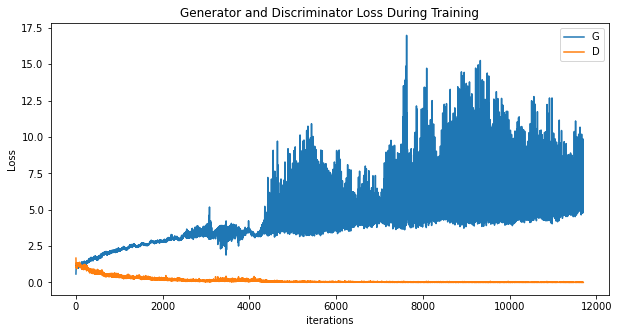

In [37]:
%matplotlib inline

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()

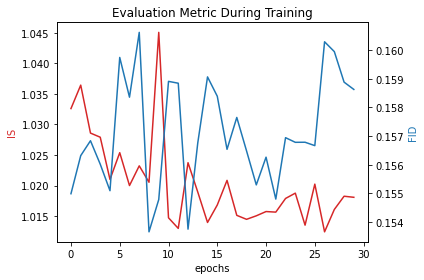

In [38]:
fig, ax1 = plt.subplots()

plt.title("Evaluation Metric During Training")

color = 'tab:red'
ax1.set_xlabel('epochs')
ax1.set_ylabel('IS', color=color)
ax1.plot(is_values, color=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('FID', color=color)
ax2.plot(fid_values, color=color)

fig.tight_layout()

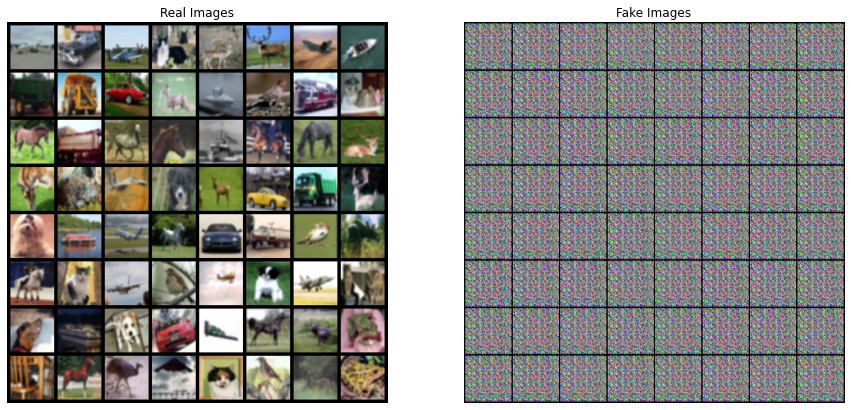

In [39]:
%matplotlib inline

# Grab a batch of real images from the dataloader
real_batch = next(iter(train_dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(vutils.make_grid(img_list[-1], padding=2, normalize=True).cpu(),(1,2,0)))